In [1]:
import numpy as np
#from scipy import stats

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import seaborn as sns

import math
import time

import pickle

#from shapely.geometry import Point

In [2]:
pkl_file = open('full_df.pkl', 'rb')

df = pickle.load(pkl_file)

pkl_file.close()

df.shape



(1361166, 121)

In [3]:
type(df)

geopandas.geodataframe.GeoDataFrame

In [4]:
#features to keep:
ftk = ['log_ttime_mean', 'log_interp_pop_gpw_sum', 'pop_cell_dens', 'log_bdist1', 'log_bdist3', 
       'log_interp_urban_ih', 'log_interp_forest_ih', 'mountains_mean', 'nlights_calib_mean', 
       'nearest_conflict', 'past_conflicts', 'log_excluded_pop', 'fatilities_country_year', 'conflict_country_year',
       'diff_median_light', 'log_country_area_sum', 'log_interp_pop_gpw_sum', 'capdist', 'pop_cell_dens_excluded_b',
       'excluded_b_low_ratio_light', 'low_ratio_light','excluded_binary', 'petroleum_full', 
       'geometry', 'gid', 'gwno', 'year',
       'best','binary_best','lead_best','lead_binary_best','log_lead_best','log_best']

#features to drop:
ftd = set(df.columns).difference(set(ftk))

# the drop:
df.drop(list(ftd), axis = 1, inplace = True)

# just correcting this
df.rename({'fatilities_country_year' : 'fatalities_country_year'}, inplace = True)

In [5]:
#drop test years:
df_full = df.copy() # full set to manage and save later on

df = df[df['year'] <= 2005].copy() #Train



# samlpe
df_s = df.sample(10000, random_state=123) # for faster plots

In [6]:
sum(df_s['lead_best'] > 0)/df_s.shape[0]
# very unbalanced

0.0098

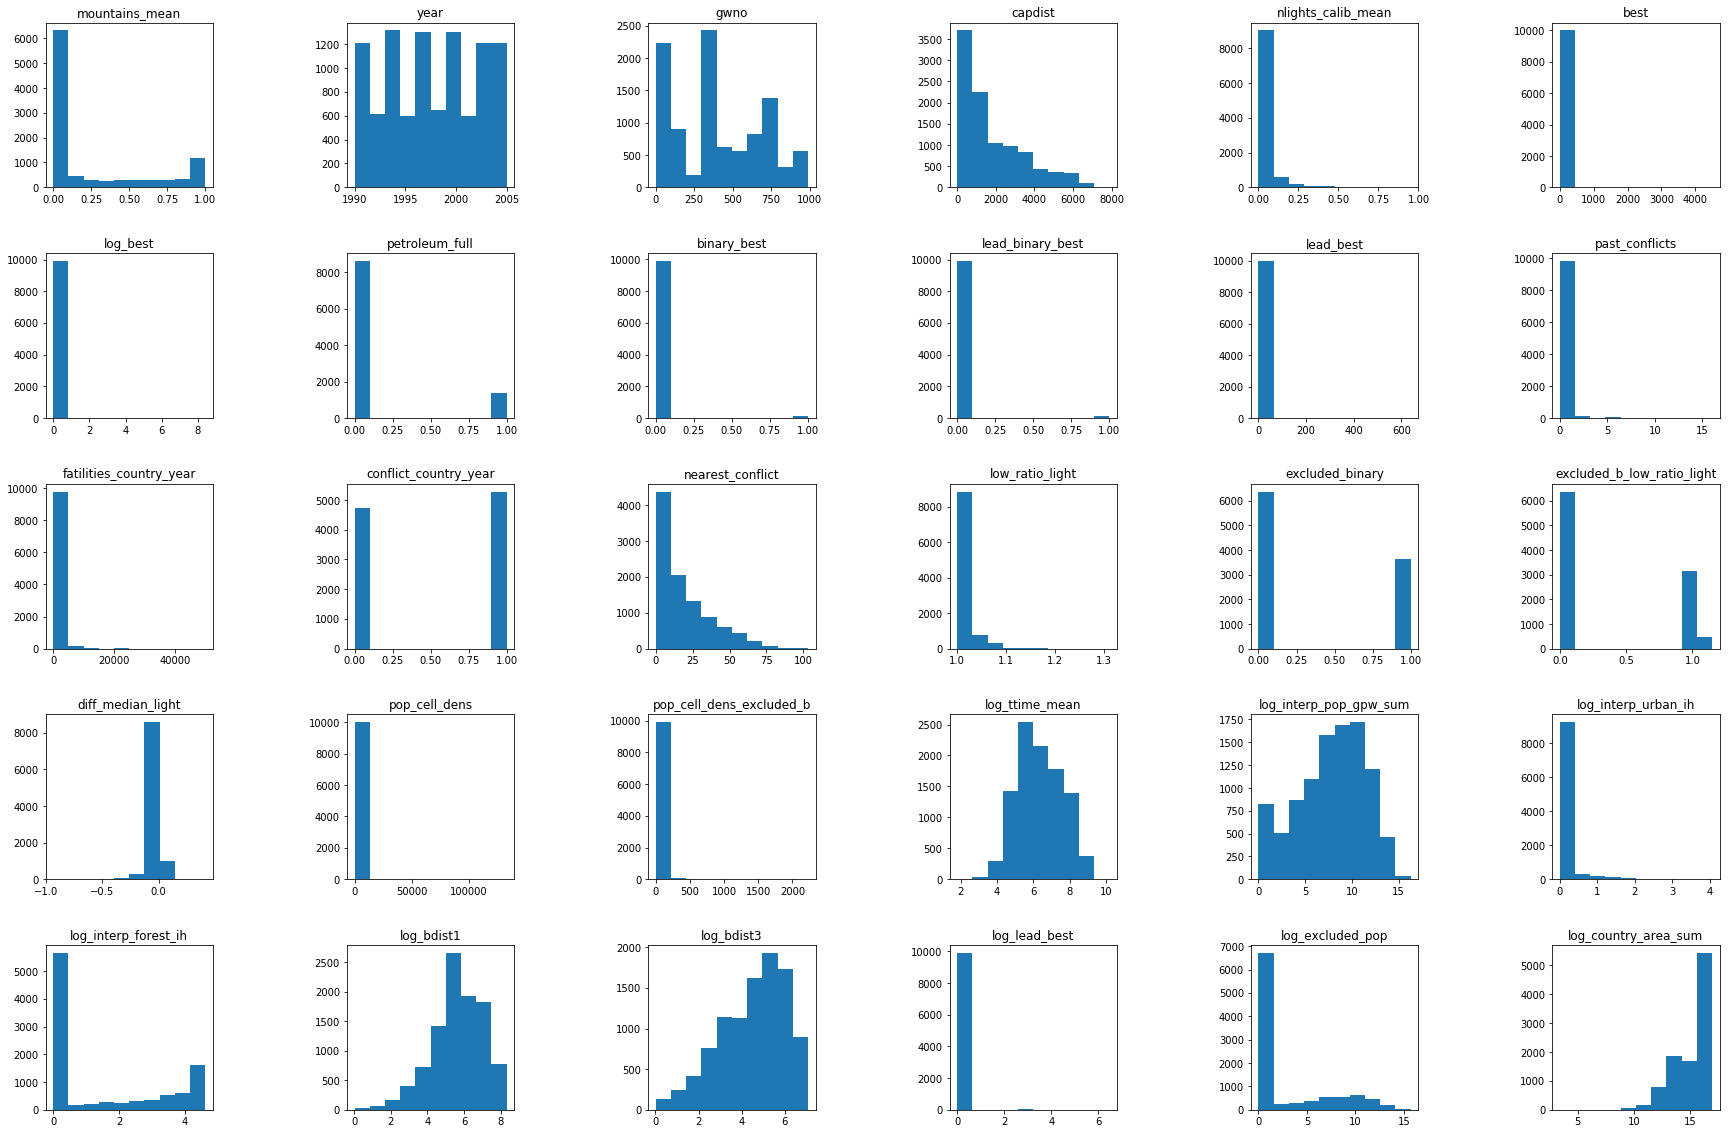

In [7]:
# her sortere du ud i logs.

def mass_hist(df=df):
    
    features = df.columns[2:]
    
    nfeatures = len(features)
    cols=6 
    rows=math.ceil(nfeatures/cols)
    
    fig = plt.figure(figsize = (30,20))
    fig.subplots_adjust(hspace = 0.4, wspace = 0.8)
        
    for i in np.arange(nfeatures):
        plot_n = i+1
        plt.subplot(rows,cols,plot_n)
        plt.hist(x=df[features[i]].dropna())
        plt.title(features[i])
                
    plt.show()

mass_hist(df=df_s)

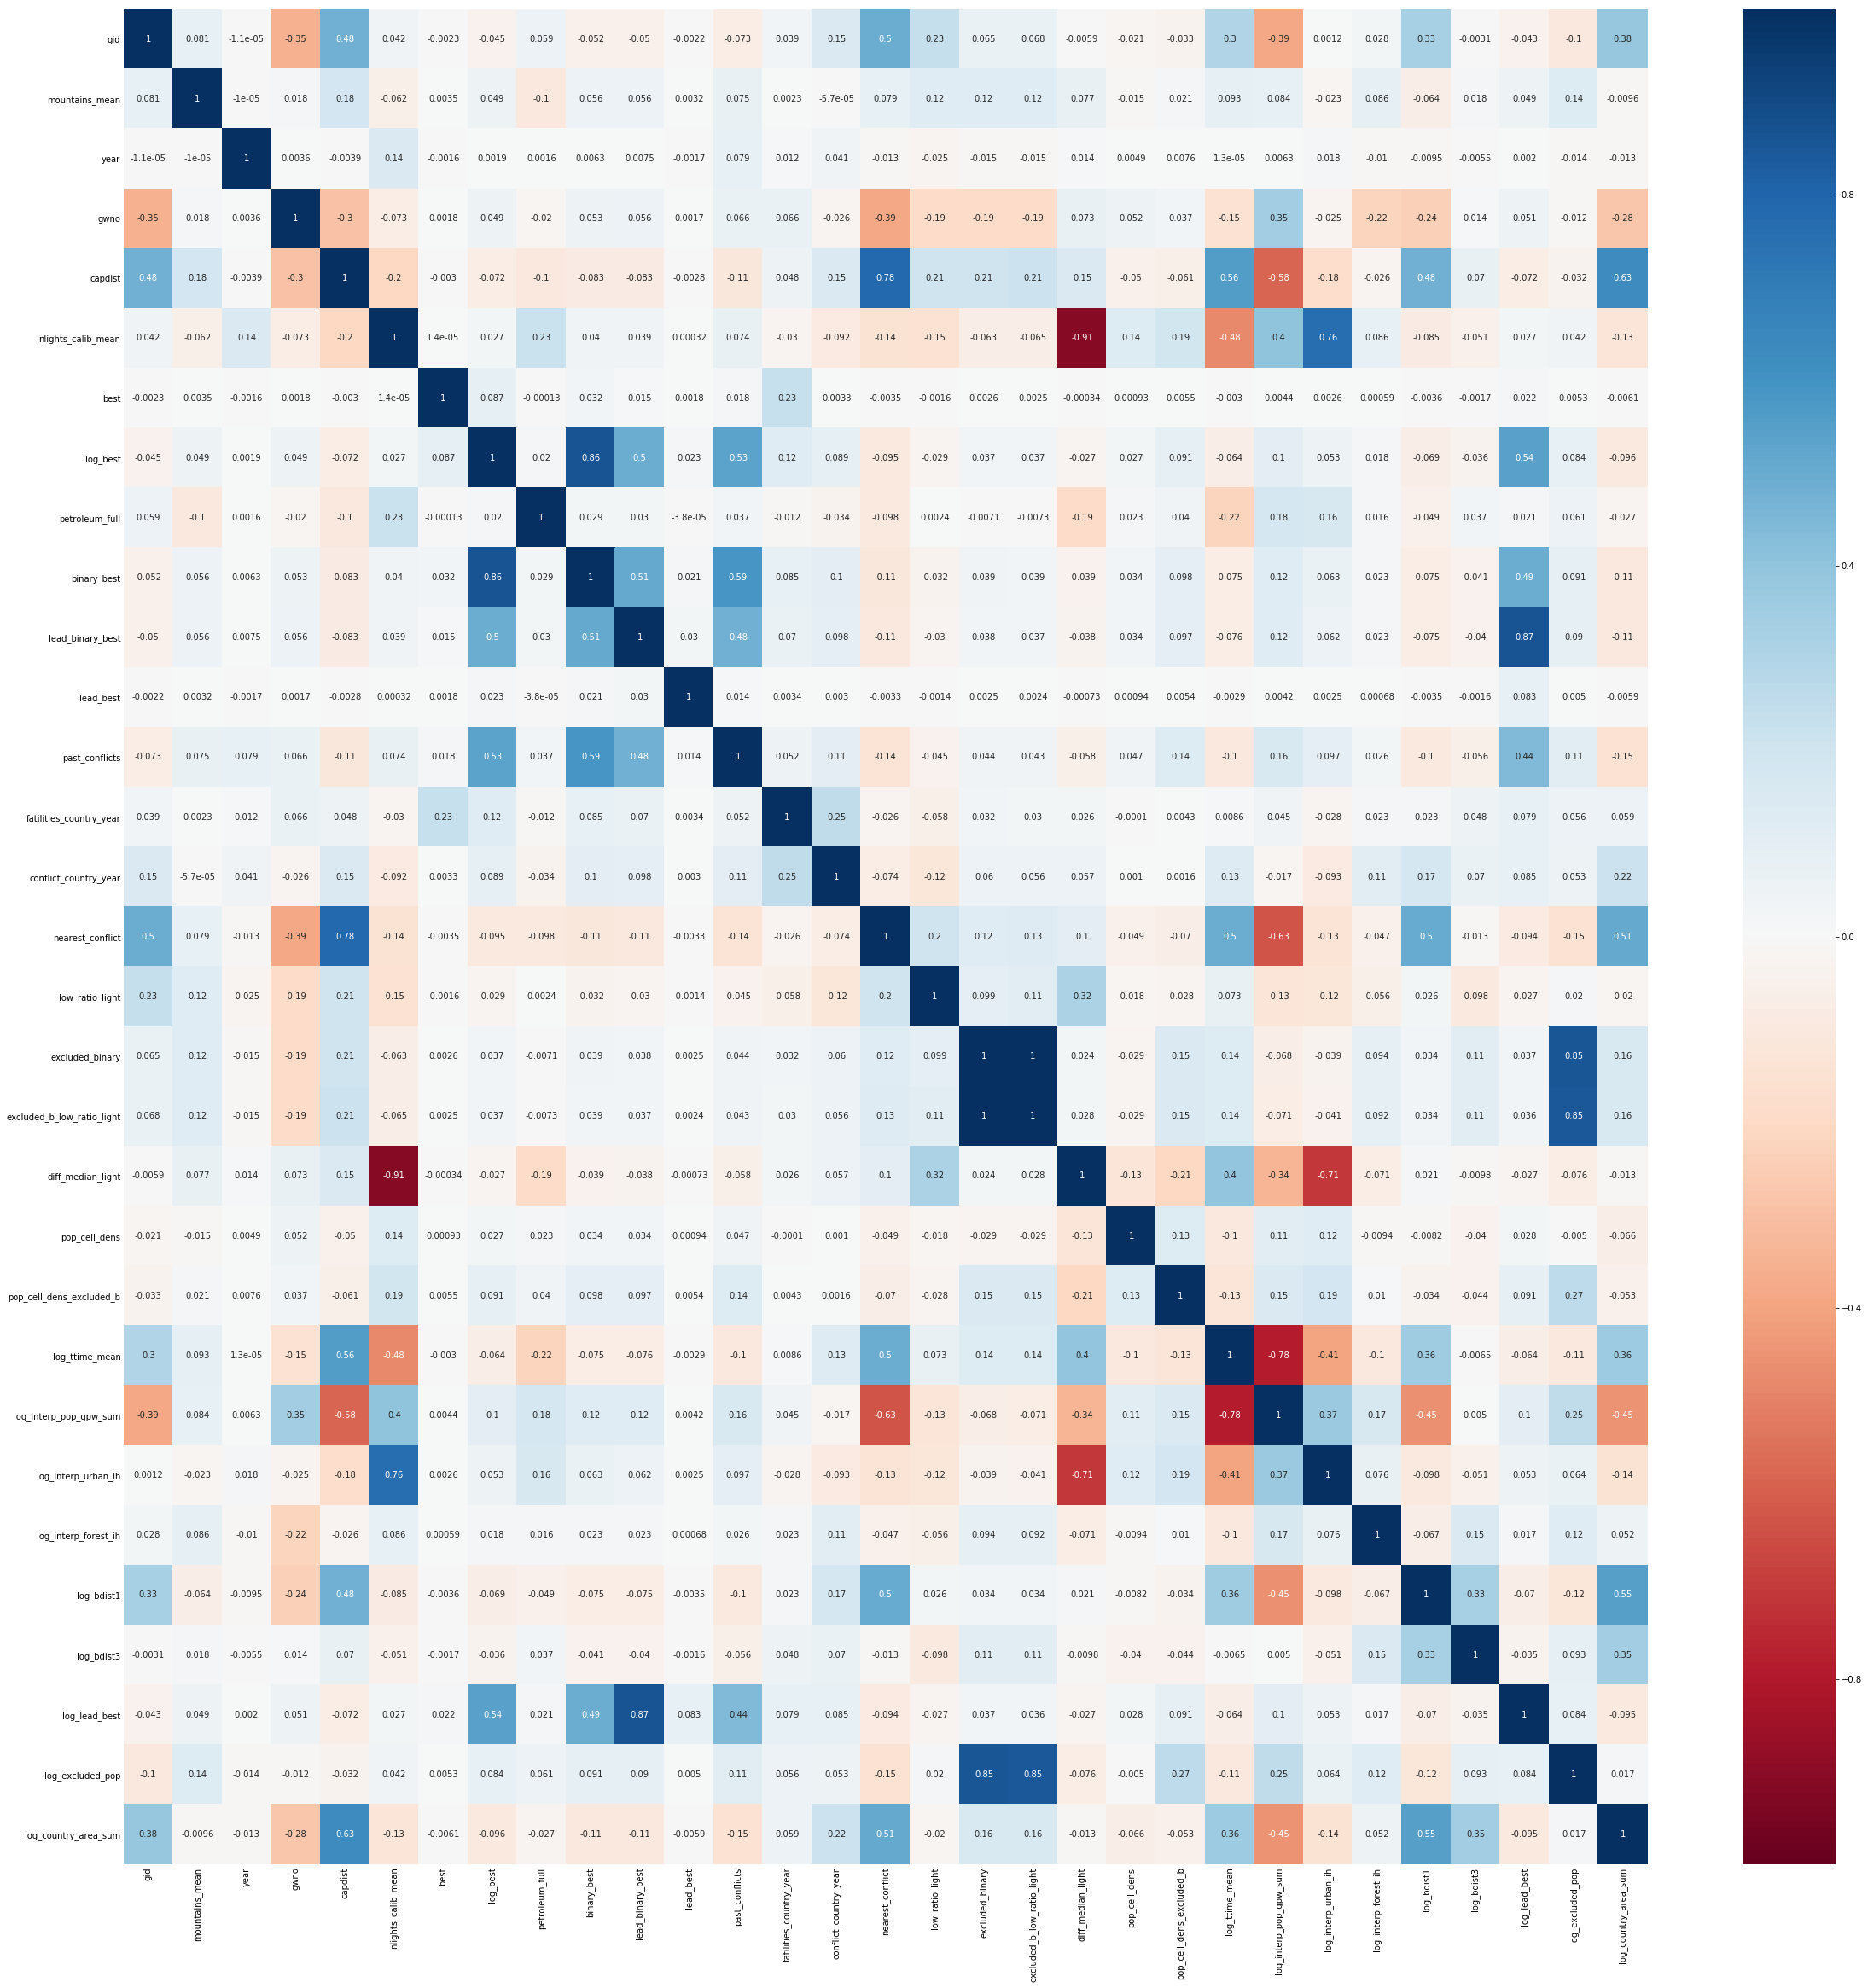

In [8]:
plt.figure(figsize=[40,40])

sns.heatmap(df.corr(),cmap="RdBu", vmin=-1, vmax=1, annot=True)

#tick_names =  ['tolerance','war exp.','distress','new path (3)','strength (5)','spirituality (8)','religious (10)']


# plt.yticks(np.arange(0.5,7.5,1),
#            tick_names, fontsize = 12)

# plt.xticks(np.arange(0.,7.,1),
#            tick_names, 
#            rotation=50, fontsize = 12)

#plt.title('Ćorrolation Matrix of the Main Features\n', fontsize = 14)
plt.tick_params(size = 0)

#fig_title = 'corr_mat_tol.pdf'
#plt.savefig(fig_title, bbox_inches="tight")

plt.show()

# impotance (RF)

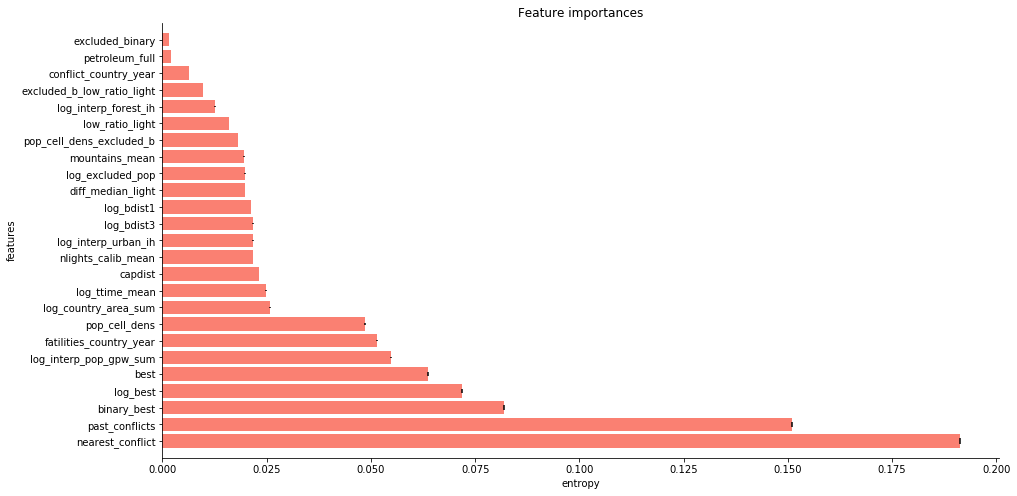

In [9]:
from sklearn.ensemble import RandomForestClassifier


features_to_drop = ['geometry','lead_binary_best', 'lead_best', 'log_lead_best','gid', 'gwno', 'year']


def fit_forest_class(features_to_drop = features_to_drop, df=df):
    
    forest = RandomForestClassifier(n_estimators=250,random_state=0,criterion='entropy',n_jobs=-1)
    
    data_small = df.dropna().copy()

    X = data_small.drop(features_to_drop, axis = 1)
        
    y = np.array(data_small['lead_binary_best'])

    forest.fit(X, y)
    
    return(forest, X, y)

forest,X,y = fit_forest_class(features_to_drop, df_s)

def importanceplot(forest = forest, X=X, xlabel = 'entropy'):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=[15,int(X.shape[1]/3)])
    plt.title("Feature importances")
    plt.barh(range(X.shape[1]), importances[indices],
       color="salmon", yerr=std[indices], align="center")

    plt.yticks(range(X.shape[1]),  X.columns[indices])
    plt.ylim([-1, X.shape[1]])

    plt.xlabel(xlabel)
    plt.ylabel('features')

    sns.despine()
    plt.show()
    
importanceplot(forest, X, 'entropy')

In [10]:
from sklearn.ensemble import RandomForestRegressor

def fit_forest_reg(features_to_drop = features_to_drop):
    
    forest = RandomForestRegressor(n_estimators=250,random_state=0,criterion='mse',n_jobs=-1)

    data_small = df_s.dropna().copy()

    X = data_small.drop(features_to_drop, axis = 1)
        
    y = np.array(data_small['lead_best'])

    forest.fit(X, y)
    
    return(forest, X, y)

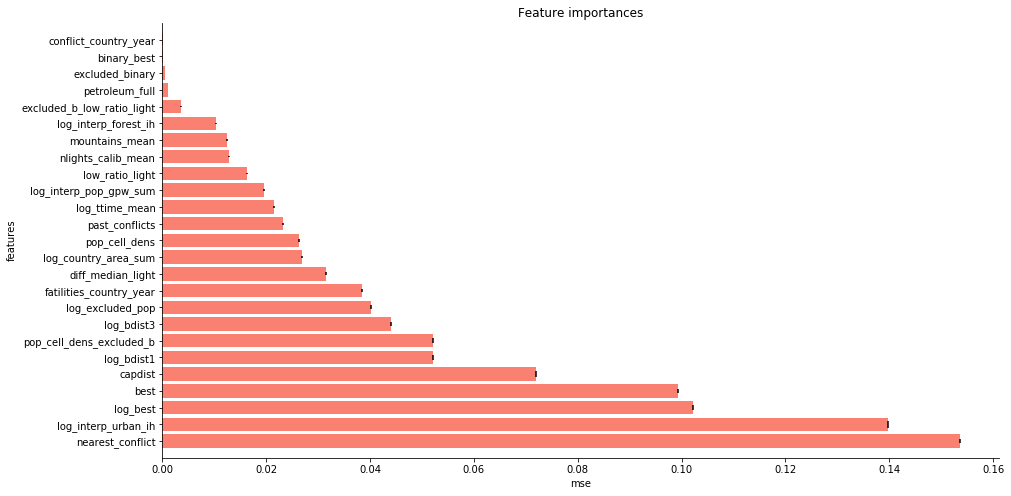

In [11]:
forest,X,y = fit_forest_reg(features_to_drop)
importanceplot(forest, X, 'mse')

In [12]:

def fit_forest_reg(features_to_drop = features_to_drop):
    
    forest = RandomForestRegressor(n_estimators=250,random_state=0,criterion='mse',n_jobs=-1)

    data_small = df_s.dropna().copy()

    X = data_small.drop(features_to_drop, axis = 1)
        
    y = np.array(data_small['log_lead_best'])

    forest.fit(X, y)
    
    return(forest, X, y)

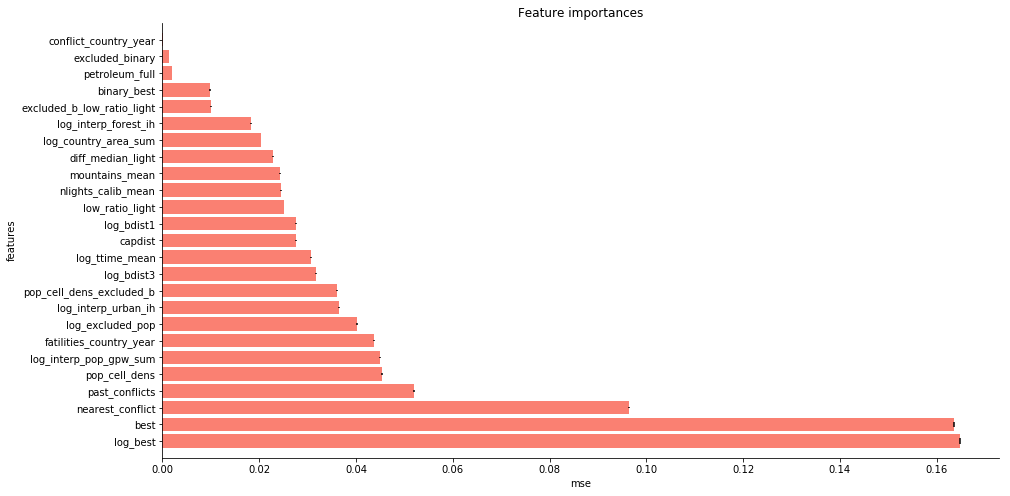

In [13]:
forest,X,y = fit_forest_reg(features_to_drop)
importanceplot(forest, X, 'mse')

# Feature selection:

In [14]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn import linear_model

data_small = df_s.dropna().copy()

X = data_small.drop(features_to_drop, axis = 1)    
y = np.array(data_small['lead_binary_best'])

# AUC:

In [15]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

auc_metric = sfs_f.get_metric_dict()

[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:    1.3s finished

[2019-01-10 11:34:13] Features: 1/10 -- score: 0.9770068693089037[Parallel(n_jobs=6)]: Done  24 out of  24 | elapsed:    1.9s finished

[2019-01-10 11:34:15] Features: 2/10 -- score: 0.980499171974164[Parallel(n_jobs=6)]: Done  23 out of  23 | elapsed:    1.8s finished

[2019-01-10 11:34:17] Features: 3/10 -- score: 0.9811517934669217[Parallel(n_jobs=6)]: Done  22 out of  22 | elapsed:    2.2s finished

[2019-01-10 11:34:20] Features: 4/10 -- score: 0.981503065816735[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    2.2s finished

[2019-01-10 11:34:23] Features: 5/10 -- score: 0.9817108726836723[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.4s finished

[2019-01-10 11:34:25] Features: 6/10 -- score: 0.9819876251308655[Parallel(n_jobs=6)]: Done


minutes it took: 0.5006530443827312



[Parallel(n_jobs=6)]: Done  16 out of  16 | elapsed:    5.2s finished

[2019-01-10 11:34:42] Features: 10/10 -- score: 0.9819870714267775

In [16]:
def first_best(selector = sfs_f):

    result = 0

    for i in np.arange(1,len(selector.k_feature_idx_)+1):

        if selector.get_metric_dict()[i]['avg_score'] > result: # > if not a neg score, ex AUC_score

            result = selector.get_metric_dict()[i]['avg_score']
            feature_index = selector.get_metric_dict()[i]['feature_idx']
            feature_names = selector.get_metric_dict()[i]['feature_names']
            n_features = len(feature_index)

        else:
            break
     
    return([n_features,result,feature_index,feature_names])

In [17]:
auc_best_set = first_best(selector = sfs_f)
auc_best_set

[8,
 0.9821113707266367,
 (2, 3, 6, 7, 9, 10, 11, 18),
 ('nlights_calib_mean',
  'best',
  'binary_best',
  'past_conflicts',
  'conflict_country_year',
  'nearest_conflict',
  'low_ratio_light',
  'log_interp_pop_gpw_sum')]

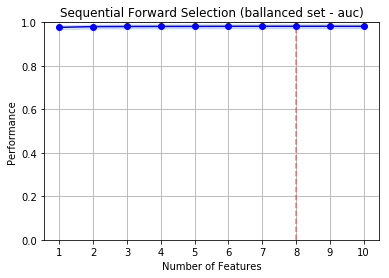

In [18]:
plot_sfs(auc_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(auc_best_set[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

# Recall:

In [19]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 2, scoring = 'recall', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

recall_metric = sfs_f.get_metric_dict()

[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:    1.3s finished

[2019-01-10 11:34:44] Features: 1/10 -- score: 0.28736842105263155[Parallel(n_jobs=6)]: Done  24 out of  24 | elapsed:    1.3s finished

[2019-01-10 11:34:46] Features: 2/10 -- score: 0.34578947368421054[Parallel(n_jobs=6)]: Done  23 out of  23 | elapsed:    1.3s finished

[2019-01-10 11:34:47] Features: 3/10 -- score: 0.3773684210526316[Parallel(n_jobs=6)]: Done  22 out of  22 | elapsed:    1.7s finished

[2019-01-10 11:34:49] Features: 4/10 -- score: 0.38736842105263153[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    2.2s finished

[2019-01-10 11:34:52] Features: 5/10 -- score: 0.3973684210526316[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.2s finished

[2019-01-10 11:34:54] Features: 6/10 -- score: 0.40736842105263155[Parallel(n_jobs=6)]


minutes it took: 0.6239354213078817



[Parallel(n_jobs=6)]: Done  16 out of  16 | elapsed:    8.9s finished

[2019-01-10 11:35:20] Features: 10/10 -- score: 0.42736842105263156

In [20]:
recall_best_set = first_best(selector = sfs_f)
recall_best_set

[7,
 0.42736842105263156,
 (4, 6, 7, 10, 11, 15, 18),
 ('log_best',
  'binary_best',
  'past_conflicts',
  'nearest_conflict',
  'low_ratio_light',
  'pop_cell_dens',
  'log_interp_pop_gpw_sum')]

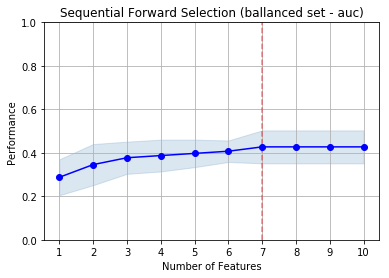

In [21]:
plot_sfs(recall_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(recall_best_set[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

# AP:

In [22]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 2, scoring = 'average_precision', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

ap_metric = sfs_f.get_metric_dict()

[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:    1.2s finished

[2019-01-10 11:35:22] Features: 1/10 -- score: 0.4517897774002783[Parallel(n_jobs=6)]: Done  24 out of  24 | elapsed:    1.4s finished

[2019-01-10 11:35:24] Features: 2/10 -- score: 0.5463629528384573[Parallel(n_jobs=6)]: Done  23 out of  23 | elapsed:    1.5s finished

[2019-01-10 11:35:25] Features: 3/10 -- score: 0.5740961514478542[Parallel(n_jobs=6)]: Done  22 out of  22 | elapsed:    1.7s finished

[2019-01-10 11:35:27] Features: 4/10 -- score: 0.592345545666381[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    2.1s finished

[2019-01-10 11:35:29] Features: 5/10 -- score: 0.5928426762914274[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.3s finished

[2019-01-10 11:35:32] Features: 6/10 -- score: 0.5933399910130588[Parallel(n_jobs=6)]: Don


minutes it took: 0.44747040669123334



[Parallel(n_jobs=6)]: Done  16 out of  16 | elapsed:    4.3s finished

[2019-01-10 11:35:47] Features: 10/10 -- score: 0.6031015236787578

In [23]:
ap_best_set = first_best(selector = sfs_f)
ap_best_set

[6,
 0.5933399910130588,
 (2, 6, 7, 9, 10, 18),
 ('nlights_calib_mean',
  'binary_best',
  'past_conflicts',
  'conflict_country_year',
  'nearest_conflict',
  'log_interp_pop_gpw_sum')]

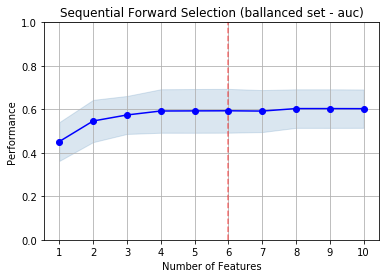

In [24]:
plot_sfs(ap_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(ap_best_set[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

-----

# But what if you drop all ongoing conflicts?

In [25]:
df_onset = df[df['best']==0].copy()
df_onset_s = df_onset.sample(10000)

In [26]:
sum(df_onset_s['lead_best'] > 0)/10000
#Now it is very onbalanced..

0.006

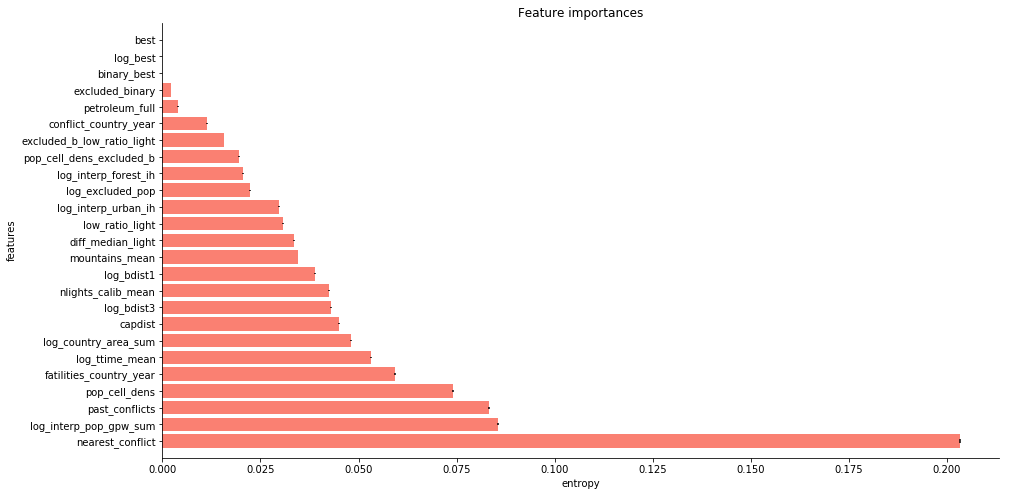

In [27]:
forest,X,y = fit_forest_class(features_to_drop, df_onset_s)
importanceplot(forest, X, 'entropy')

In [28]:
data_small = df_onset_s.dropna().copy()

X = data_small.drop(features_to_drop, axis = 1)    
y = np.array(data_small['lead_binary_best'])

In [29]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 2, scoring = 'roc_auc', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

auc_onset_metric = sfs_f.get_metric_dict()

[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:    1.4s finished

[2019-01-10 11:35:54] Features: 1/10 -- score: 0.9348045912217978[Parallel(n_jobs=6)]: Done  24 out of  24 | elapsed:    1.5s finished

[2019-01-10 11:35:55] Features: 2/10 -- score: 0.9404939812369655[Parallel(n_jobs=6)]: Done  23 out of  23 | elapsed:    1.5s finished

[2019-01-10 11:35:57] Features: 3/10 -- score: 0.9413174285975462[Parallel(n_jobs=6)]: Done  22 out of  22 | elapsed:    1.5s finished

[2019-01-10 11:35:59] Features: 4/10 -- score: 0.9423168555835432[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    1.6s finished

[2019-01-10 11:36:01] Features: 5/10 -- score: 0.94258557545164[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.8s finished

[2019-01-10 11:36:03] Features: 6/10 -- score: 0.9431649967159611[Parallel(n_jobs=6)]: Done


minutes it took: 0.4206749161084493



[Parallel(n_jobs=6)]: Done  16 out of  16 | elapsed:    4.6s finished

[2019-01-10 11:36:17] Features: 10/10 -- score: 0.9435933437271471

In [30]:
auc_onset_best_set = first_best(selector = sfs_f)
auc_onset_best_set

[8,
 0.9435933437271471,
 (0, 2, 7, 10, 11, 14, 17, 18),
 ('mountains_mean',
  'nlights_calib_mean',
  'past_conflicts',
  'nearest_conflict',
  'low_ratio_light',
  'diff_median_light',
  'log_ttime_mean',
  'log_interp_pop_gpw_sum')]

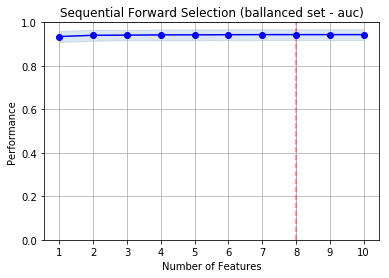

In [31]:
plot_sfs(auc_onset_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(auc_onset_best_set[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [32]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 15, forward = True, verbose = 2, scoring = 'recall', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

recall_onset_metric = sfs_f.get_metric_dict()

[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:    1.4s finished

[2019-01-10 11:36:19] Features: 1/15 -- score: 0.05[Parallel(n_jobs=6)]: Done  24 out of  24 | elapsed:    1.5s finished

[2019-01-10 11:36:21] Features: 2/15 -- score: 0.05[Parallel(n_jobs=6)]: Done  23 out of  23 | elapsed:    1.7s finished

[2019-01-10 11:36:23] Features: 3/15 -- score: 0.05[Parallel(n_jobs=6)]: Done  22 out of  22 | elapsed:    2.9s finished

[2019-01-10 11:36:27] Features: 4/15 -- score: 0.05[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    3.0s finished

[2019-01-10 11:36:30] Features: 5/15 -- score: 0.05[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.7s finished

[2019-01-10 11:36:33] Features: 6/15 -- score: 0.05[Parallel(n_jobs=6)]: Done  19 out of  19 | elapsed:    2.7s finished

[2019-01-10 11:36:36] Features: 7/15 


minutes it took: 0.9388049880663554



[Parallel(n_jobs=6)]: Done  11 out of  11 | elapsed:    4.1s finished

[2019-01-10 11:37:14] Features: 15/15 -- score: 0.05

In [33]:
# best_set = first_best(selector = sfs_f)
# best_set

In [34]:
recall_onset_best_set = sfs_f.get_metric_dict()[10]
recall_onset_best_set

{'avg_score': 0.05,
 'ci_bound': 0.08568606122049131,
 'cv_scores': array([0.        , 0.16666667, 0.        , 0.        , 0.08333333]),
 'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
 'feature_names': ('mountains_mean',
  'capdist',
  'nlights_calib_mean',
  'best',
  'log_best',
  'petroleum_full',
  'binary_best',
  'past_conflicts',
  'fatilities_country_year',
  'conflict_country_year'),
 'std_dev': 0.06666666666666668,
 'std_err': 0.03333333333333333}

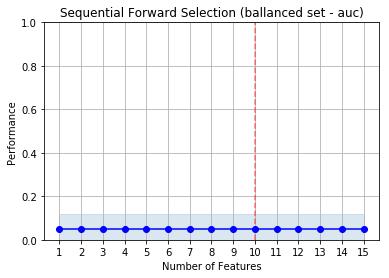

In [35]:
plot_sfs(recall_onset_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(len(recall_onset_best_set['feature_idx']), 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [36]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 10, forward = True, verbose = 2, scoring = 'average_precision', cv = 5, n_jobs = 6)

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

ap_onset_metric = sfs_f.get_metric_dict()

[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:    1.2s finished

[2019-01-10 11:37:16] Features: 1/10 -- score: 0.18631786021022[Parallel(n_jobs=6)]: Done  24 out of  24 | elapsed:    1.5s finished

[2019-01-10 11:37:18] Features: 2/10 -- score: 0.23654147845811205[Parallel(n_jobs=6)]: Done  23 out of  23 | elapsed:    1.8s finished

[2019-01-10 11:37:20] Features: 3/10 -- score: 0.24333628994651973[Parallel(n_jobs=6)]: Done  22 out of  22 | elapsed:    1.7s finished

[2019-01-10 11:37:22] Features: 4/10 -- score: 0.24516886833702198[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  21 out of  21 | elapsed:    1.7s finished

[2019-01-10 11:37:24] Features: 5/10 -- score: 0.24666176728971637[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    2.1s finished

[2019-01-10 11:37:26] Features: 6/10 -- score: 0.24852842684304233[Parallel(n_jobs=6)]:


minutes it took: 0.593359633286794



[Parallel(n_jobs=6)]: Done  16 out of  16 | elapsed:    6.5s finished

[2019-01-10 11:37:50] Features: 10/10 -- score: 0.24772551413107746

In [37]:
ap_onset_best_set = first_best(selector = sfs_f)
ap_onset_best_set

[6,
 0.24852842684304233,
 (7, 9, 10, 11, 15, 18),
 ('past_conflicts',
  'conflict_country_year',
  'nearest_conflict',
  'low_ratio_light',
  'pop_cell_dens',
  'log_interp_pop_gpw_sum')]

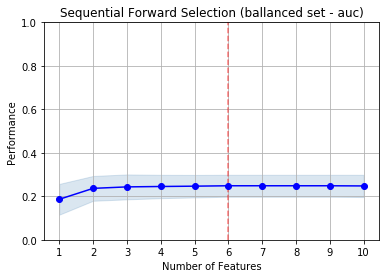

In [38]:
plot_sfs(ap_onset_metric, kind='std_dev')
plt.ylim([0, 1])

plt.vlines(ap_onset_best_set[0], 0, 1, 'red', 'dashed', alpha = 0.5)

plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [39]:
recall_onset_best_set

{'avg_score': 0.05,
 'ci_bound': 0.08568606122049131,
 'cv_scores': array([0.        , 0.16666667, 0.        , 0.        , 0.08333333]),
 'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
 'feature_names': ('mountains_mean',
  'capdist',
  'nlights_calib_mean',
  'best',
  'log_best',
  'petroleum_full',
  'binary_best',
  'past_conflicts',
  'fatilities_country_year',
  'conflict_country_year'),
 'std_dev': 0.06666666666666668,
 'std_err': 0.03333333333333333}

In [40]:
from collections import Counter

selected_fetures_list = auc_best_set[3] + recall_best_set[3] + ap_best_set[3] + auc_onset_best_set[3] + recall_onset_best_set['feature_names'] + ap_onset_best_set[3]    

c_selected = Counter(selected_fetures_list)

c_selected


Counter({'best': 2,
         'binary_best': 4,
         'capdist': 1,
         'conflict_country_year': 4,
         'diff_median_light': 1,
         'fatilities_country_year': 1,
         'log_best': 2,
         'log_interp_pop_gpw_sum': 5,
         'log_ttime_mean': 1,
         'low_ratio_light': 4,
         'mountains_mean': 2,
         'nearest_conflict': 5,
         'nlights_calib_mean': 4,
         'past_conflicts': 6,
         'petroleum_full': 1,
         'pop_cell_dens': 2})

# I choose:

- **fatilities_country_year**

- **log_best**

- **log_country_area_sum**

- **low_ratio_light**

- **nearest_conflict**

- **nlights_calib_mean**

- **past_conflicts**

Take **excluded_b** and **petroleum_full** along for shits and giggles. And try to swap low_ligt_ratio with diff_median_light and see what happans

In [49]:
df_chosen = df_full[['fatilities_country_year', 'log_best', 'log_country_area_sum', 'low_ratio_light', 
                      'nearest_conflict','nlights_calib_mean','past_conflicts','excluded_binary', 
                      'petroleum_full','lead_binary_best','diff_median_light',
                      'gid','gwno','year', 'geometry']].copy()

In [50]:
type(df_chosen)

geopandas.geodataframe.GeoDataFrame

In [51]:
df_chosen.shape

(1361166, 15)

In [52]:
df_chosen.head()

,fatilities_country_year,log_best,log_country_area_sum,low_ratio_light,nearest_conflict,nlights_calib_mean,past_conflicts,excluded_binary,petroleum_full,lead_binary_best,diff_median_light,gid,gwno,year,geometry
13,0.0,0.0,16.109234,1.011347,64.271494,0.0,0,0,0.0,0.0,0.0,249328,20.0,1990,"POLYGON ((-76.5 83, -76.5 83.5, -76 83.5, -76 ..."
34,0.0,0.0,16.109234,1.011347,64.242704,0.0,0,0,0.0,0.0,0.0,249329,20.0,1990,"POLYGON ((-76 83, -76 83.5, -75.5 83.5, -75.5 ..."
55,0.0,0.0,16.109234,1.011347,64.217793,0.0,0,0,0.0,0.0,0.0,249330,20.0,1990,"POLYGON ((-75.5 83, -75.5 83.5, -75 83.5, -75 ..."
76,0.0,0.0,16.109234,1.011347,64.196768,0.0,0,0,0.0,0.0,0.0,249331,20.0,1990,"POLYGON ((-75 83, -75 83.5, -74.5 83.5, -74.5 ..."
97,0.0,0.0,16.109234,1.011347,64.179631,0.0,0,0,0.0,0.0,0.0,249332,20.0,1990,"POLYGON ((-74.5 83, -74.5 83.5, -74 83.5, -74 ..."


In [53]:
import pickle 
    
file_name = "chosen_df.pkl"
output = open(file_name, 'wb') # still not working right!!
pickle.dump(df, output)
output.close()